In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Set random seed for reproducibility
#np.random.seed(42)

# Function to generate mock data for tasks and robots
def generate_mock_data(num_tasks=10, num_robots=5):
    task_durations = np.random.randint(1, 11, size=num_tasks)  # Random task durations between 1 and 10 hours
    task_priorities = np.random.randint(1, 6, size=num_tasks)  # Random task priorities between 1 and 5
    robot_efficiencies = np.random.uniform(0.5, 1.5, size=num_robots)  # Random robot efficiencies between 0.5 and 1.5
    print(task_durations, task_priorities, robot_efficiencies)
    return task_durations, task_priorities, robot_efficiencies


In [ ]:

def fitness_function( assignment, task_durations, task_priorities, robot_efficiencies):
    """
    Calculates the fitness of a given task assignment.

    Args:
        task_durations: List of task durations.
        task_priorities: List of task priorities.
        robot_efficiencies: List of robot efficiencies.
        assignment: List of task assignments to robots.

    Returns:
        The fitness value.
    """

    # Calculate the total duration of tasks assigned to each robot
    robot_workloads = [0] * len(robot_efficiencies)
    for task, robot in enumerate(assignment):
        robot_workloads[robot] += task_durations[task] / robot_efficiencies[robot]

    # Calculate the total time taken to complete all tasks
    T_total = max(robot_workloads)

    # Calculate the workload distribution among robots
    workload_distribution = np.std(robot_workloads)

    # Calculate the fitness value
    fitness = 1 / (T_total + workload_distribution)

    return fitness


In [ ]:
def select_parents(population, fitness_values, pop_size, num_tasks, tournament_size=2):
    parents = np.empty((pop_size, num_tasks), dtype=int)
    for i in range(pop_size):
        tournament_indices = np.random.choice(pop_size, tournament_size, replace=False)
        best_parent_idx = tournament_indices[np.argmin(fitness_values[tournament_indices])]
        parents[i] = population[best_parent_idx]
    return parents


In [ ]:
def crossover(parents, crossover_rate, pop_size, num_tasks):
    offspring = np.empty((pop_size, num_tasks), dtype=int)
    for i in range(0, pop_size, 2):
        if np.random.rand() < crossover_rate:
            crossover_point = np.random.randint(1, num_tasks)
            offspring[i] = np.concatenate((parents[i, :crossover_point], parents[i+1, crossover_point:]))
            offspring[i+1] = np.concatenate((parents[i+1, :crossover_point], parents[i, crossover_point:]))
        else:
            offspring[i] = parents[i]
            offspring[i+1] = parents[i+1]
    return offspring

In [ ]:
def mutate(offspring, mutation_rate, pop_size, num_tasks, num_robots):
    for i in range(pop_size):
        for j in range(num_tasks):
            if np.random.rand() < mutation_rate:
                offspring[i, j] = np.random.randint(num_robots)
    return offspring

In [ ]:
def select_next_generation(combined_population, combined_fitness_values, pop_size):
    # Select next generation based on fitness values
    sorted_indices = np.argsort(combined_fitness_values)
    next_generation = combined_population[sorted_indices[:pop_size]]
    next_fitness_values = combined_fitness_values[sorted_indices[:pop_size]]
    return next_generation, next_fitness_values

Genetic Algorithm

In [ ]:

def run_genetic_algorithm(task_durations, task_priorities, robot_efficiencies):
    # Hyperparameters
    pop_size = 100
    num_tasks = len(task_durations)
    num_robots = len(robot_efficiencies)
    crossover_rate = 0.7
    mutation_rate = 0.2
    num_generations = 50
    tournament_size = 3
    tasks = []
    for i in range(len(robot_efficiencies)):
      tasks.append(list(range(10)))
    # Initialize population
    population = np.random.randint(num_robots, size=(pop_size, num_tasks))
    # Run genetic algorithm
    for generation in range(num_generations):
        # Calculate fitness values
        fitness_values = np.array([fitness_function(population[generation], task_durations, task_priorities, robot_efficiencies) for i in range(pop_size)])

        # Select parents
        parents = select_parents(population, fitness_values, pop_size, num_tasks, tournament_size)

        # Crossover
        offspring = crossover(parents, crossover_rate, pop_size, num_tasks)

        # Mutation
        offspring = mutate(offspring, mutation_rate, pop_size, num_tasks, num_robots)

        # Combine population and offspring
        for i in offspring :
          offspring_fitness = fitness_function(i, task_durations, task_priorities, robot_efficiencies)


        combined_population = np.vstack((population, offspring))
        combined_fitness_values = np.hstack((fitness_values, offspring_fitness))

        # Select next generation
        population, fitness_values = select_next_generation(combined_population, combined_fitness_values, pop_size)

    # Find best solution
    best_idx = np.argmax(fitness_values)
    best_solution = population[best_idx]
    best_fitness = fitness_values[best_idx]

    return best_solution

In [ ]:
def visualize_assignments_improved(solution, task_durations, task_priorities, robot_efficiencies):
    # Create a grid for visualization based on the solution provided
    grid = np.zeros((len(robot_efficiencies), len(task_durations)))
    for task_idx, robot_idx in enumerate(solution):
        grid[robot_idx, task_idx] = task_durations[task_idx]

    fig, ax = plt.subplots(figsize=(12, 6))
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["white", "magenta"])  # Custom colormap

    # Display the grid with task durations
    cax = ax.matshow(grid, cmap=cmap)
    fig.colorbar(cax, label='Task Duration (hours)')

    # Annotate each cell with task priority and duration
    for i in range(len(robot_efficiencies)):
        for j in range(len(task_durations)):
            ax.text(j, i, f'P{task_priorities[j]}\n{task_durations[j]}h', va='center', ha='center')


    # Set the ticks and labels for tasks and robots
    ax.set_xticks(np.arange(len(task_durations)))
    ax.set_yticks(np.arange(len(robot_efficiencies)))
    ax.set_xticklabels([f'Task {i+1}' for i in range(len(task_durations))], rotation=45, ha="left")
    ax.set_yticklabels([f'Robot {i+1} (Efficiency: {eff:.2f})' for i, eff in enumerate(robot_efficiencies)])

    plt.xlabel('Tasks')
    plt.ylabel('Robots')
    plt.title('Task Assignments with Task Duration and Priority')

    # Create a legend for task priorities
    priority_patches = [mpatches.Patch(color='white', label=f'Priority {i}') for i in range(1, 6)]
    plt.legend(handles=priority_patches, bbox_to_anchor=(1.20, 1), loc='upper left', title="Task Priorities")

    plt.tight_layout()
    plt.show()

[8 7 2 2 8 5 6 2 3 9] [4 1 1 2 3 2 4 4 1 3] [0.99418857 0.80844571 0.77911495 0.85361466 1.31127481]
[3 2 1 0 2 4 4 3 0 4]


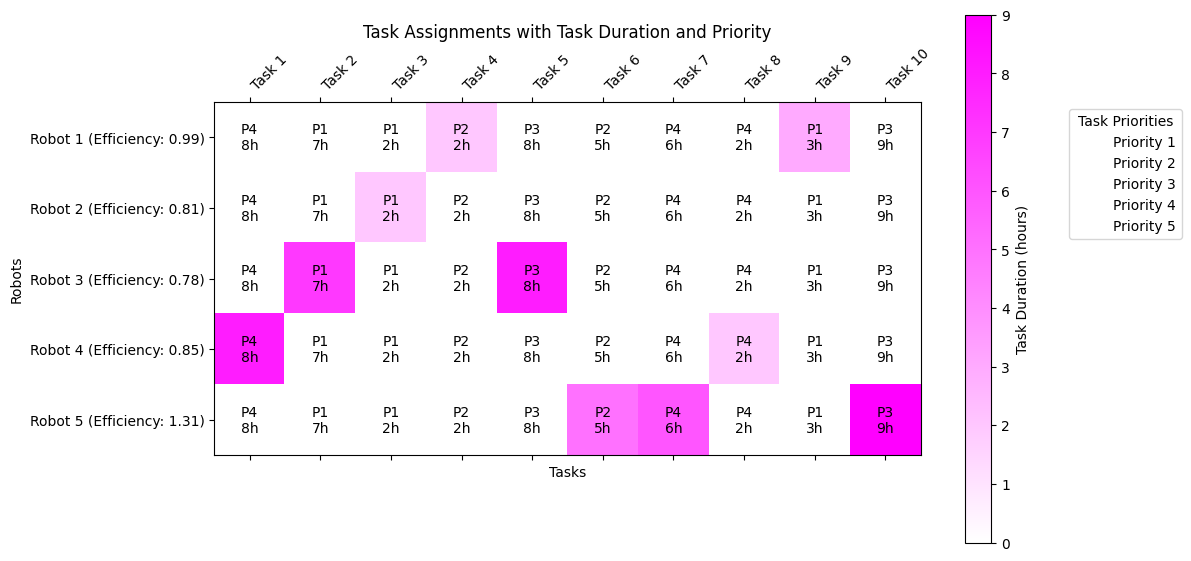

In [ ]:
if __name__ == "__main__":
    num_tasks = 10
    num_robots = 5
    task_durations, task_priorities, robot_efficiencies = generate_mock_data(num_tasks, num_robots)

    # Run GA to find the best solution
    best_solution = run_genetic_algorithm(task_durations, task_priorities, robot_efficiencies)
    print(best_solution)

    # Visualize the initial random assignment
    visualize_assignments_improved(best_solution, task_durations, task_priorities, robot_efficiencies)
